In [1]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install pandas
!pip install seaborn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/41/6f/53606bacb79e64f30d23410e15f3034447e97a33850d5d4366abdcf7ed84/scikeras-0.11.0-py3-none-any.whl.metadata


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
import PIL as image_lib
import tensorflow as tf
from PIL import Image
from keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score

In [10]:
def read_textfile_row_by_row(filepath):
    with open(filepath, 'r') as file:
        name_array = []
        for line in file:
            line_array = line.strip().split(';')
            if line_array:
                    name_array.append(line_array[0])
                
    return name_array

traintxt = r"TSRD\TSRD-Train Annotation\TsignRecgTrain4170Annotation.txt"
train_name = read_textfile_row_by_row(traintxt)

image_path = r"TSRD\tsrd-train" + "\\" + train_name[0]
print(image_path)

TSRD\tsrd-train\000_0001.png


# Preprocessing

In [11]:
# Function to resize an image with aspect ratio preservation
def resize_image_with_aspect_ratio(image, target_size=(64, 64)):
    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the aspect ratio of the original image
    aspect_ratio = original_width / original_height

    # Calculate new dimensions while maintaining aspect ratio
    target_width, target_height = target_size
    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image using bilinear interpolation to maintain colors
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Create an empty canvas of the target size
    canvas = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width, :] = resized_image
    
    # Convert the canvas back to BGR color space
    canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)
    
    # Normalize pixel values to the range [0, 1]
    normalized_image = canvas_bgr / 255.0
    
    return normalized_image

In [12]:
import os
import cv2
import pandas as pd

# Directory containing your images
directory_path = r"TSRD\tsrd-train"

# List all image files in the directory
image_files = [f for f in os.listdir(directory_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Initialize dictionaries to map image filenames to labels
image_to_label = {}

# Read labels from the provided text file and populate the dictionary
with open(r"TSRD\TSRD-Train Annotation\TsignRecgTrain4170Annotation.txt", 'r') as f:
    for line in f:
        parts = line.strip().split(';')
        image_filename = parts[0]
        label = parts[7]
        image_to_label[image_filename] = label

# Initialize lists to store resized images and their corresponding labels
resized_images_list = []
file_label = []

for image_file in image_files:
    # Construct the full image path
    image_path = os.path.join(directory_path, image_file)

    # Read the image
    image = cv2.imread(image_path)

    # Check if the image was successfully loaded
    if image is not None:
        # Resize the image to 64x64 pixels while maintaining aspect ratio
        image = resize_image_with_aspect_ratio(image, target_size=(64, 64))
        
        # Append the resized image to the list
        resized_images_list.append(image)
        
        # Get the label for the image from the dictionary
        label = image_to_label.get(image_file, None)
        file_label.append(label)  # Append the label to the list
    else:
        print(f"Error: Unable to read image from {image_path}")

# Now, resized_images_list contains the resized images, and labels_list contains their corresponding labels.


In [13]:
# Extract labels and count the unique classes
unique_classes = set(file_label)
num_classes = len(unique_classes)

# Print the unique classes and the total number of classes
print("Unique Classes:", unique_classes)
print("Total Number of Classes:", num_classes)

Unique Classes: {'47', '16', '22', '6', '46', '48', '33', '7', '9', '13', '15', '4', '56', '12', '21', '45', '37', '32', '24', '38', '39', '3', '10', '44', '23', '0', '27', '53', '41', '11', '2', '26', '28', '55', '19', '17', '20', '18', '25', '49', '54', '36', '57', '1', '30', '43', '50', '31', '42', '34', '8', '51', '29', '14', '40', '52', '35', '5'}
Total Number of Classes: 58


In [8]:
print(len(resized_images_list))
print(resized_images_list[0])
print(len(file_label))
print(file_label)

4170
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.51372549 0.44705882 0.38431373]
  [0.51372549 0.44313725 0.38431373]
  [0.51764706 0.44705882 0.38431373]
  ...
  [0.4        0.34117647 0.30196078]
  [0.4        0.34117647 0.29411765]
  [0.4        0.34901961 0.29803922]]

 [[0.5254902  0.44313725 0.38823529]
  [0.52156863 0.43921569 0.38431373]
  [0.51372549 0.44313725 0.38431373]
  ...
  [0.40784314 0.35294118 0.30196078]
  [0.40784314 0.35294118 0.30196078]
  [0.40784314 0.35294118 0.30588235]]

 ...

 [[0.61568627 0.09803922 0.23137255]
  [0.60784314 0.10980392 0.22352941]
  [0.65490196 0.43921569 0.48627451]
  ...
  [0.22352941 0.20784314 0.19215686]
  [0.34509804 0.32941176 0.28627451]
  [0.35686275 0.3254902  0.28627451]]

 [[0.         0.         0.        ]
  [0.         0.         0.     

In [9]:
print(len(resized_images_list))

4170


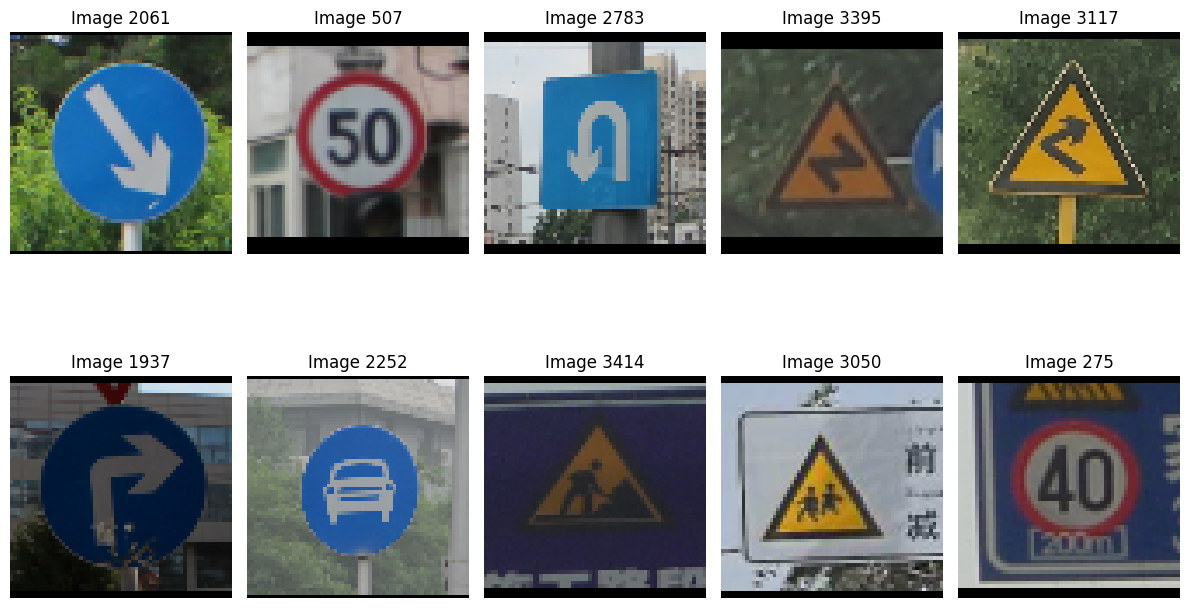

In [10]:
import random
import matplotlib.pyplot as plt

# Set the number of random images you want to load
num_images_to_load = 10

# Get the total number of images in your dataset
total_images = len(resized_images_list)

# Generate random indices to select random images
random_indices = random.sample(range(total_images), num_images_to_load)

# Load and display the random images
plt.figure(figsize=(12, 8))

for i, random_index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(resized_images_list[random_index])
    plt.title(f"Image {random_index}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
# Convert the list of resized images to a NumPy array
resized_images_array = np.array(resized_images_list)
labels_array = np.array(file_label)
print(resized_images_array.shape)
print(labels_array.shape)

(4170, 64, 64, 3)
(4170,)


In [12]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((resized_images_array, labels_array))

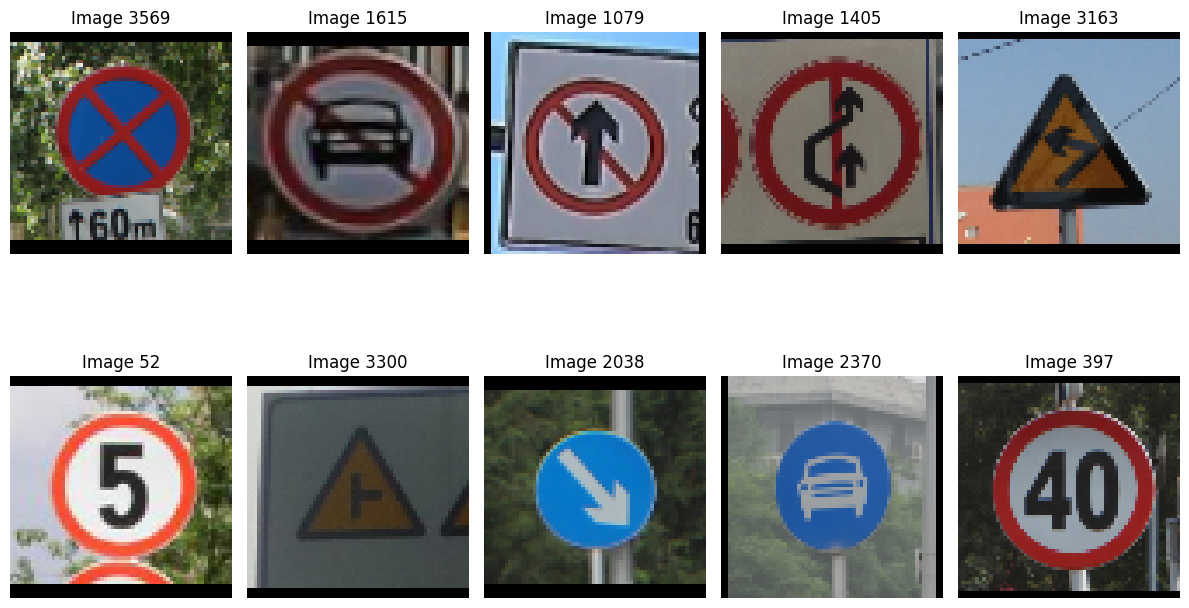

In [13]:
import random
import matplotlib.pyplot as plt

# Set the number of random images you want to load
num_images_to_load = 10

# Get the total number of images in your dataset
total_images = len(resized_images_array)

# Generate random indices to select random images
random_indices = random.sample(range(total_images), num_images_to_load)

# Load and display the random images
plt.figure(figsize=(12, 8))

for i, random_index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(resized_images_array[random_index])
    plt.title(f"Image {random_index}")
    plt.axis("off")

plt.tight_layout()
plt.show()


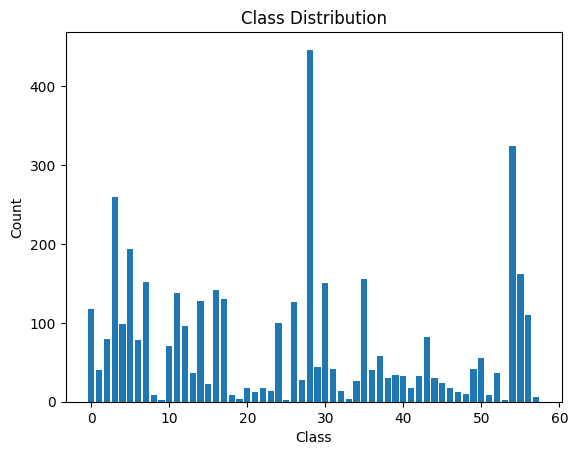

In [14]:
# Convert the labels dataset to a NumPy array and ensure it's of integer data type
labels_array = np.array(list(dataset.map(lambda image, label: label).as_numpy_iterator()), dtype=np.int32)

# Count the occurrences of each class
class_counts = np.bincount(labels_array)

# Plot the class distribution
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [15]:
# Print the class distribution
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: Count = {count}")

Class 0: Count = 118
Class 1: Count = 40
Class 2: Count = 80
Class 3: Count = 260
Class 4: Count = 98
Class 5: Count = 194
Class 6: Count = 78
Class 7: Count = 152
Class 8: Count = 8
Class 9: Count = 2
Class 10: Count = 70
Class 11: Count = 138
Class 12: Count = 96
Class 13: Count = 36
Class 14: Count = 128
Class 15: Count = 22
Class 16: Count = 142
Class 17: Count = 130
Class 18: Count = 8
Class 19: Count = 4
Class 20: Count = 18
Class 21: Count = 12
Class 22: Count = 18
Class 23: Count = 14
Class 24: Count = 100
Class 25: Count = 2
Class 26: Count = 126
Class 27: Count = 28
Class 28: Count = 446
Class 29: Count = 44
Class 30: Count = 150
Class 31: Count = 42
Class 32: Count = 14
Class 33: Count = 4
Class 34: Count = 26
Class 35: Count = 156
Class 36: Count = 40
Class 37: Count = 58
Class 38: Count = 30
Class 39: Count = 34
Class 40: Count = 32
Class 41: Count = 18
Class 42: Count = 32
Class 43: Count = 82
Class 44: Count = 30
Class 45: Count = 24
Class 46: Count = 18
Class 47: Count 

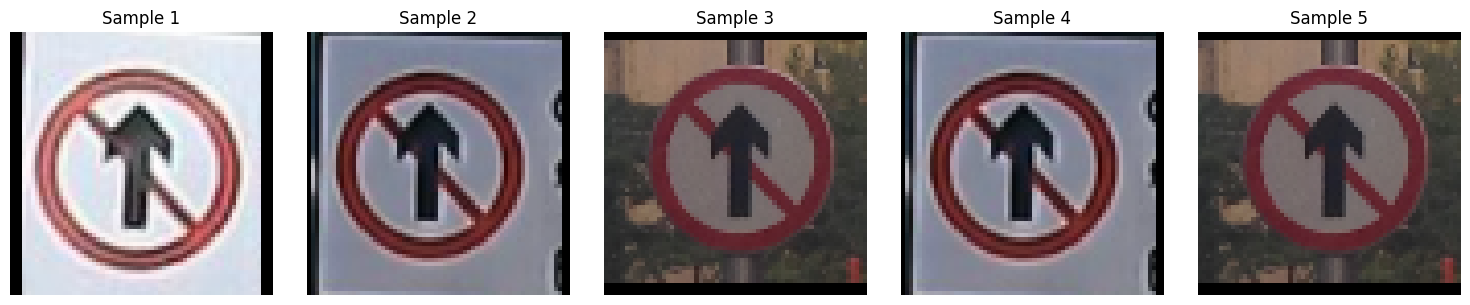

In [16]:
import matplotlib.pyplot as plt
import random

# Define the class for which you want to check and plot images
class_to_check = 10  # Replace with the class you want to check
num_images_to_plot = 5  # Number of images to plot

# Get the indices of the samples from the oversampled class_to_check
indices_class_to_check = np.where(labels_array == class_to_check)[0]

# Randomly select num_images_to_plot random indices from the class_to_check
random_indices = random.sample(list(indices_class_to_check), num_images_to_plot)

# Create a subplot with 1 row and num_images_to_plot columns
plt.figure(figsize=(15, 3))
for i, index in enumerate(random_indices):
    image = resized_images_array[index]
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(image)
    plt.title(f"Sample {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data Augmentation

In [17]:
import numpy as np
from sklearn.utils import resample

# Combine resized_images_array and labels_array into a single dataset
train_data = np.c_[resized_images_array.reshape(len(resized_images_array), -1), labels_array]

# Separate the data by class
class_data = {}
for i in range(num_classes):  # Replace 'num_classes' with the number of your classes
    class_data[i] = train_data[train_data[:, -1] == i]

# Calculate the target number of samples per class (e.g., the maximum class count)
target_samples = max([len(class_data[i]) for i in range(num_classes)])

# Oversample each class to reach the target number of samples
oversampled_data = []
for i in range(num_classes):
    if len(class_data[i]) <= target_samples:
        oversampled_class_data = resample(class_data[i], n_samples=target_samples, random_state=42)
        oversampled_data.append(oversampled_class_data)

# Combine oversampled data from all classes
oversampled_data = np.vstack(oversampled_data)

# Split the oversampled data into features (X_train_oversampled) and labels (y_train_oversampled)
X_train_oversampled = oversampled_data[:, :-1].reshape(-1, 64, 64, 3)
y_train_oversampled = oversampled_data[:, -1]

# Now, X_train_oversampled and y_train_oversampled contain the oversampled training data


Class 0.0: 446 samples
Class 1.0: 446 samples
Class 2.0: 446 samples
Class 3.0: 446 samples
Class 4.0: 446 samples
Class 5.0: 446 samples
Class 6.0: 446 samples
Class 7.0: 446 samples
Class 8.0: 446 samples
Class 9.0: 446 samples
Class 10.0: 446 samples
Class 11.0: 446 samples
Class 12.0: 446 samples
Class 13.0: 446 samples
Class 14.0: 446 samples
Class 15.0: 446 samples
Class 16.0: 446 samples
Class 17.0: 446 samples
Class 18.0: 446 samples
Class 19.0: 446 samples
Class 20.0: 446 samples
Class 21.0: 446 samples
Class 22.0: 446 samples
Class 23.0: 446 samples
Class 24.0: 446 samples
Class 25.0: 446 samples
Class 26.0: 446 samples
Class 27.0: 446 samples
Class 28.0: 446 samples
Class 29.0: 446 samples
Class 30.0: 446 samples
Class 31.0: 446 samples
Class 32.0: 446 samples
Class 33.0: 446 samples
Class 34.0: 446 samples
Class 35.0: 446 samples
Class 36.0: 446 samples
Class 37.0: 446 samples
Class 38.0: 446 samples
Class 39.0: 446 samples
Class 40.0: 446 samples
Class 41.0: 446 samples
Cl

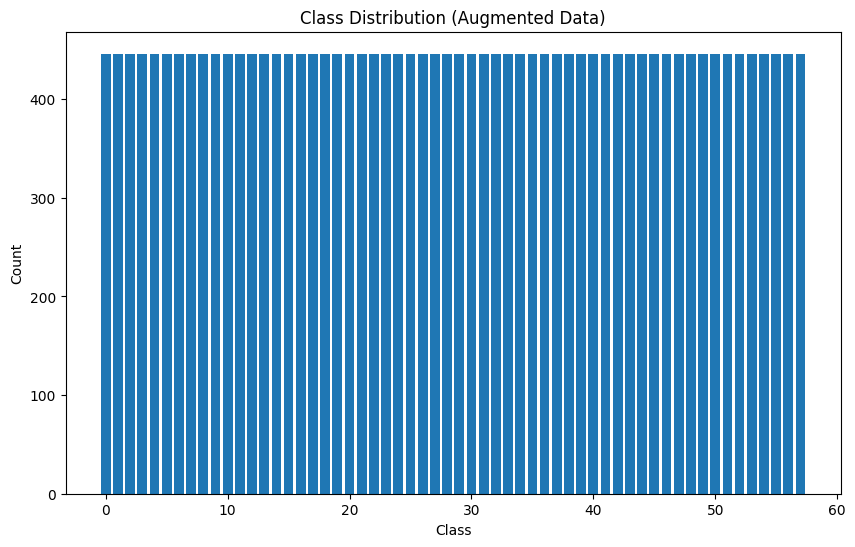

In [18]:

# Count the number of samples per class in augmented_y
class_counts_augmented = dict(zip(*np.unique(y_train_oversampled, return_counts=True)))

# Print the class distribution for augmented data
for label, count in class_counts_augmented.items():
    print(f"Class {label}: {count} samples")

# If you want to visualize it as a bar plot:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(class_counts_augmented.keys(), class_counts_augmented.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (Augmented Data)")
plt.show()


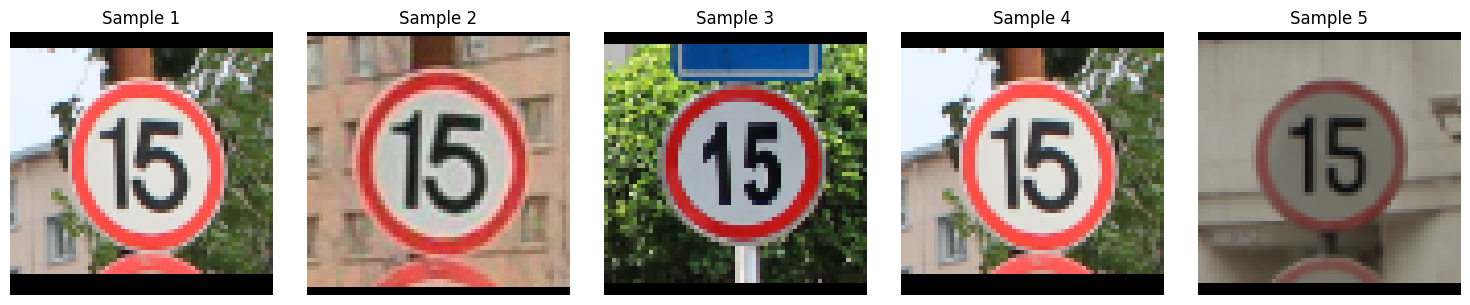

In [19]:
import matplotlib.pyplot as plt
import random

# Define the class for which you want to check and plot images
class_to_check = 1  # Replace with the class you want to check
num_images_to_plot = 5  # Number of images to plot

# Get the indices of the samples from the oversampled class_to_check
indices_class_to_check = np.where(y_train_oversampled == class_to_check)[0]

# Randomly select num_images_to_plot random indices from the class_to_check
random_indices = random.sample(list(indices_class_to_check), num_images_to_plot)

# Create a subplot with 1 row and num_images_to_plot columns
plt.figure(figsize=(15, 3))
for i, index in enumerate(random_indices):
    image = X_train_oversampled[index]
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(image)
    plt.title(f"Sample {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
train_size = len(X_train_oversampled)

print(f"Training dataset size: {train_size} samples")
print(X_train_oversampled.shape)
print(y_train_oversampled.shape)

Training dataset size: 25868 samples
(25868, 64, 64, 3)
(25868,)


In [21]:
# Assuming y_train and y_val are your class labels as integers
num_classes = len(np.unique(file_label))

# One-hot encode the target labels
y_train_oversampled = tf.keras.utils.to_categorical(y_train_oversampled, num_classes)


In [22]:
from sklearn.model_selection import train_test_split

# Split the oversampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_oversampled, y_train_oversampled, test_size=0.2, random_state=42)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(20694, 64, 64, 3)
(20694, 58)
(5174, 64, 64, 3)
(5174, 58)


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size= 32
# Create data generators for training and validation data (assuming you have X_train, y_train, X_val, and y_val)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)

# CNN model

In [26]:


# Define the function to create your custom CNN model
def create_custom_model(learning_rate=0.001, dropout_rate=0.3, optimizer='adam'):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Create the KerasClassifier instance
model = KerasClassifier(build_fn=create_custom_model, verbose=0)

# Define hyperparameter grid without 'learning_rate'
param_grid = {
    'batch_size': [32, 64, 128, 256],
    'optimizer': ['adam', 'rmsprop']
}

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit the grid search to your data
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


MemoryError: Unable to allocate 647. MiB for an array with shape (6898, 64, 64, 3) and data type float64

In [27]:


# Create a more advanced model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


# Compile the model with a lower initial learning rate and a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                        

In [28]:
# Define the callback functions
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,  # Adjust the number of epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[model_check, early, reduce_lr]  # Include the learning rate scheduler and other callbacks
)

#Optionally, you can save the trained model
#model.save('custom.h5')

Epoch 1/30
647/647 [==============================] - ETA: 0s - loss: 2.4860 - accuracy: 0.3528
Epoch 1: val_accuracy improved from -inf to 0.67124, saving model to best_model.h5
647/647 [==============================] - 85s 130ms/step - loss: 2.4860 - accuracy: 0.3528 - val_loss: 1.1333 - val_accuracy: 0.6712 - lr: 0.0010
Epoch 2/30


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


647/647 [==============================] - ETA: 0s - loss: 1.4125 - accuracy: 0.5791
Epoch 2: val_accuracy improved from 0.67124 to 0.75319, saving model to best_model.h5
647/647 [==============================] - 90s 139ms/step - loss: 1.4125 - accuracy: 0.5791 - val_loss: 0.7639 - val_accuracy: 0.7532 - lr: 9.0000e-04
Epoch 3/30
647/647 [==============================] - ETA: 0s - loss: 1.0161 - accuracy: 0.6892
Epoch 3: val_accuracy improved from 0.75319 to 0.84847, saving model to best_model.h5
647/647 [==============================] - 89s 138ms/step - loss: 1.0161 - accuracy: 0.6892 - val_loss: 0.4542 - val_accuracy: 0.8485 - lr: 9.0000e-04
Epoch 4/30
647/647 [==============================] - ETA: 0s - loss: 0.7970 - accuracy: 0.7500
Epoch 4: val_accuracy improved from 0.84847 to 0.91167, saving model to best_model.h5
647/647 [==============================] - 88s 137ms/step - loss: 0.7970 - accuracy: 0.7500 - val_loss: 0.2763 - val_accuracy: 0.9117 - lr: 8.1000e-04
Epoch 5/30
6

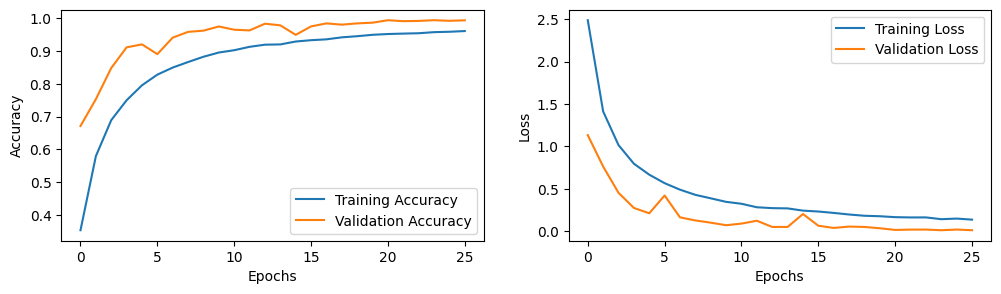

In [31]:

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Testing

In [14]:


# Directory containing your images
directory_path = r"NewTest\TSRD-Test"

# List all image files in the directory
image_files = [f for f in os.listdir(directory_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Initialize dictionaries to map image filenames to labels
image_to_test = {}

# Read labels from the provided text file and populate the dictionary
with open(r"NewTest\TSRD-Test Annotation\TsignRecgTest1994Annotation.txt", 'r') as f:
    for line in f:
        parts = line.strip().split(';')
        image_filename = parts[0]
        label = parts[7]
        image_to_test[image_filename] = label

# Initialize lists to store resized images and their corresponding labels
resized_images_test = []
test_label = []

for image_file in image_files:
    # Construct the full image path
    image_path = os.path.join(directory_path, image_file)

    # Read the image
    image = cv2.imread(image_path)

    # Check if the image was successfully loaded
    if image is not None:
        # Resize the image to 64x64 pixels while maintaining aspect ratio
        image = resize_image_with_aspect_ratio(image, target_size=(64, 64))
        
        # Append the resized image to the list
        resized_images_test.append(image)
        
        # Get the label for the image from the dictionary
        label = image_to_test.get(image_file, None)
        test_label.append(label)  # Append the label to the list
    else:
        print(f"Error: Unable to read image from {image_path}")

# Now, resized_images_list contains the resized images, and labels_list contains their corresponding labels.



In [15]:
print(len(resized_images_test))
print(resized_images_test[1])


2006
[[[0.         0.         0.        ]
  [0.12156863 0.12941176 0.15686275]
  [0.15294118 0.15686275 0.18431373]
  ...
  [0.14509804 0.16078431 0.18039216]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.14117647 0.14901961 0.17647059]
  [0.21176471 0.21568627 0.24313725]
  ...
  [0.14509804 0.15686275 0.17254902]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.19607843 0.20392157 0.23137255]
  [0.25098039 0.25882353 0.28235294]
  ...
  [0.1254902  0.1372549  0.14509804]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.13333333 0.13333333 0.13333333]
  [0.11372549 0.11372549 0.1254902 ]
  ...
  [0.62745098 0.6        0.50588235]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.12156863 0.12156863 0.10588

In [47]:
print(len(test_label))

2006


In [48]:
# Extract labels and count the unique classes
unique_classes = set(test_label)
test_classes = len(unique_classes)

# Print the unique classes and the total number of classes
print("Unique Classes:", unique_classes)
print("Total Number of Classes:", test_classes)

Unique Classes: {'48', '10', '13', '14', '32', '55', '4', '15', '16', '56', '7', '17', '6', '40', '5', '29', '28', '27', '9', '50', '53', '8', '42', '43', '41', '52', '45', '23', '26', '21', '2', '46', '47', '44', '11', '38', '51', '19', '36', '30', '25', '33', '49', '12', '18', '31', '37', '0', '24', '34', '3', '35', '57', '22', '39', '54', '20', '1'}
Total Number of Classes: 58


In [49]:
x_test = np.array(resized_images_test)
print("x_test shape:", x_test.shape)
y_test = np.array(test_label)
print("y_test shape:", y_test.shape)

x_test shape: (2006, 64, 64, 3)
y_test shape: (2006,)


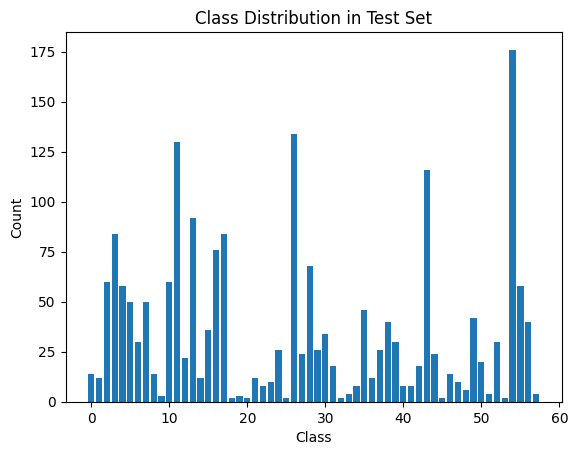

In [50]:
# Count the occurrences of each class in y_test
test_counts = np.bincount(test_label)

# Plot the class distribution
plt.bar(range(len(test_counts)), test_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Test Set')
plt.show()

In [51]:
# Print the class distribution
for class_label, count in enumerate(test_counts):
    print(f"Class {class_label}: Count = {count}")

Class 0: Count = 14
Class 1: Count = 12
Class 2: Count = 60
Class 3: Count = 84
Class 4: Count = 58
Class 5: Count = 50
Class 6: Count = 30
Class 7: Count = 50
Class 8: Count = 14
Class 9: Count = 3
Class 10: Count = 60
Class 11: Count = 130
Class 12: Count = 22
Class 13: Count = 92
Class 14: Count = 12
Class 15: Count = 36
Class 16: Count = 76
Class 17: Count = 84
Class 18: Count = 2
Class 19: Count = 3
Class 20: Count = 2
Class 21: Count = 12
Class 22: Count = 8
Class 23: Count = 10
Class 24: Count = 26
Class 25: Count = 2
Class 26: Count = 134
Class 27: Count = 24
Class 28: Count = 68
Class 29: Count = 26
Class 30: Count = 34
Class 31: Count = 18
Class 32: Count = 2
Class 33: Count = 4
Class 34: Count = 8
Class 35: Count = 46
Class 36: Count = 12
Class 37: Count = 26
Class 38: Count = 40
Class 39: Count = 30
Class 40: Count = 8
Class 41: Count = 8
Class 42: Count = 18
Class 43: Count = 116
Class 44: Count = 24
Class 45: Count = 2
Class 46: Count = 14
Class 47: Count = 10
Class 48: C

In [58]:
model = load_model('best_model.h5')
# Make predictions on the test data
predictions = model.predict(x_test)

# Assuming you have a list of class labels, you can find the class with the highest probability for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Convert the true labels to integers if they are not already
y_test = y_test.astype(np.int32)

# Calculate accuracy using scikit-learn's accuracy_score
accuracy = accuracy_score(y_test, predicted_classes)

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

63/63 [==============================] - 2s 30ms/step
Accuracy: 51.74%


In [53]:
# Calculate test accuracy for each class
unique_classes = np.unique(y_test)
class_accuracy = {}

for class_label in unique_classes:
    correct_predictions = np.sum((y_test == class_label) & (predicted_classes == class_label))
    total_samples = np.sum(y_test == class_label)
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    class_accuracy[class_label] = accuracy

# Display test accuracy for each class
for class_label, accuracy in class_accuracy.items():
    print(f"Class {class_label}: Test Accuracy = {accuracy:.2f}")

Class 0: Test Accuracy = 0.71
Class 1: Test Accuracy = 0.83
Class 2: Test Accuracy = 0.17
Class 3: Test Accuracy = 0.64
Class 4: Test Accuracy = 0.66
Class 5: Test Accuracy = 0.12
Class 6: Test Accuracy = 0.13
Class 7: Test Accuracy = 0.00
Class 8: Test Accuracy = 1.00
Class 9: Test Accuracy = 0.00
Class 10: Test Accuracy = 0.97
Class 11: Test Accuracy = 0.66
Class 12: Test Accuracy = 1.00
Class 13: Test Accuracy = 0.07
Class 14: Test Accuracy = 0.33
Class 15: Test Accuracy = 0.00
Class 16: Test Accuracy = 0.89
Class 17: Test Accuracy = 0.24
Class 18: Test Accuracy = 0.00
Class 19: Test Accuracy = 0.33
Class 20: Test Accuracy = 1.00
Class 21: Test Accuracy = 0.17
Class 22: Test Accuracy = 0.50
Class 23: Test Accuracy = 0.60
Class 24: Test Accuracy = 0.38
Class 25: Test Accuracy = 1.00
Class 26: Test Accuracy = 0.54
Class 27: Test Accuracy = 0.92
Class 28: Test Accuracy = 0.29
Class 29: Test Accuracy = 1.00
Class 30: Test Accuracy = 0.18
Class 31: Test Accuracy = 0.67
Class 32: Test Acc

In [54]:
# Convert the labels dataset to a NumPy array and ensure it's of integer data type
y_train = np.array(list(dataset.map(lambda image, label: label).as_numpy_iterator()), dtype=np.int32)

# Get unique class labels in the training set
unique_train_classes = set(y_train)

# Get unique class labels in the test set
unique_test_classes = set(y_test)

# Find the missing classes in the test set
missing_classes = unique_train_classes - unique_test_classes

print("Missing Classes:", missing_classes)


Missing Classes: set()


In [55]:
# Define the path to the directory containing your training images
train_directory_path = r"TSRD\tsrd-train"

# Define a list of missing class labels
missing_class_labels = ["9", "18", "19", "33"]

# Loop through each missing class label
for missing_class_label in missing_class_labels:
    # Initialize a list to store image filenames belonging to the missing class
    missing_class_images = []

    # Iterate through the training directory to find images of the missing class
    for root, dirs, files in os.walk(train_directory_path):
        for filename in files:
            # Construct the full image path
            image_path = os.path.join(root, filename)
            
            # Extract the label from the image filename (assuming the label is part of the filename)
            image_label = filename.split('_')[0]  # Modify this depending on your filename format
            
            # Check if the image belongs to the missing class
            if image_label == missing_class_label:
                missing_class_images.append(image_path)

    # Choose a random image from the list of missing class images
    if missing_class_images:
        random_image_path = random.choice(missing_class_images)
        
        # Read and display the chosen image
        image = cv2.imread(random_image_path)
        if image is not None:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f"Missing Class Label: {missing_class_label}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Error: Unable to read image from {random_image_path}")
    else:
        print(f"No images found for missing class label '{missing_class_label}'.")


No images found for missing class label '9'.
No images found for missing class label '18'.
No images found for missing class label '19'.
No images found for missing class label '33'.


In [56]:
# Display overall classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.36      0.83      0.50        12
           2       0.36      0.17      0.23        60
           3       0.60      0.64      0.62        84
           4       0.26      0.66      0.37        58
           5       0.18      0.12      0.14        50
           6       1.00      0.13      0.24        30
           7       0.00      0.00      0.00        50
           8       0.48      1.00      0.65        14
           9       0.00      0.00      0.00         3
          10       0.46      0.97      0.62        60
          11       0.84      0.66      0.74       130
          12       0.31      1.00      0.47        22
          13       0.43      0.07      0.11        92
          14       1.00      0.33      0.50        12
          15       0.00      0.00      0.00        36
          16       0.83      0.89      0.86        76
   

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

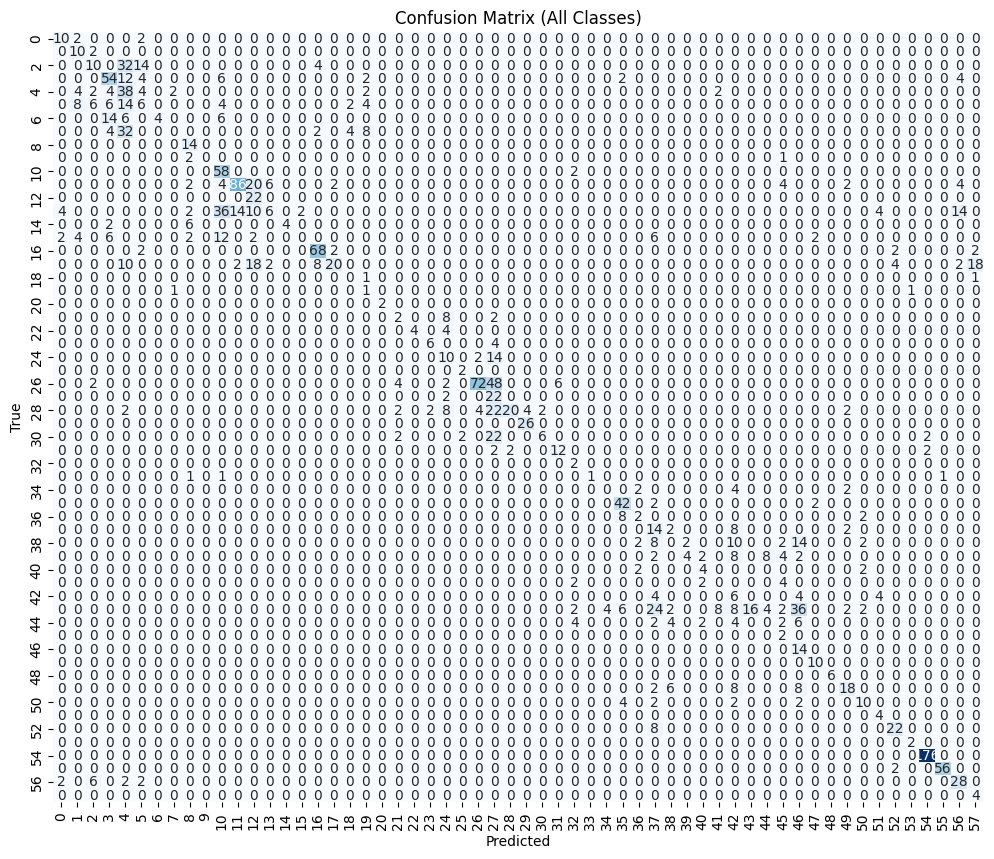

In [57]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Increase the size of the confusion matrix plot
plt.figure(figsize=(12, 10))

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (All Classes)')

# Save the plot as an image
plt.savefig('confusion_matrix_large.png')

# Show the plot (optional)
plt.show()